<a href="https://colab.research.google.com/github/anupa-aa/ML-AI-Courswork-Module/blob/master/Anupa_Adikary_ex1_OptimisationRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

**Expectation:** find solution to MSE regression using GD, Line search, GD with Momentum and 2nd Order Method, and gradient free methods.


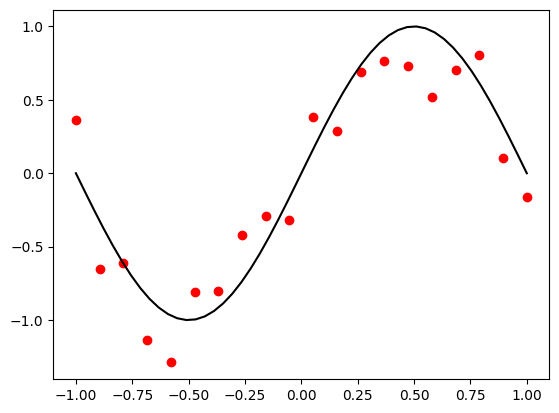

In [ ]:
#Linear Regression for general functions
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import math
import random
pi=math.pi

data_set_size = 20
noise_level = 0.3

# generate 20 numbers from -1 to 1 with equal stepsize
x=np.linspace(-1,1,data_set_size)

# generate training target (noise contaminated!)
y=np.sin(2*pi*.5*x)+noise_level*np.random.randn(x.size)

# plot the training data points
plt.plot(x, y, 'ro')

# plot the true function
plt.plot(np.linspace(-1,1,50), np.sin(2*pi*.5*np.linspace(-1,1,50)), 'black')

In [ ]:
N = x.shape[0]
M = 10
X = []
for i in range(M+1):
  X.append(x**i)

X = np.array(X).T

print('x',X.shape)
print('y',y.shape)


x (20, 11)
y (20,)


In yesterday's class we found theta $\theta$ using the closed form solution, today we first find $\theta$ using Gradient Decent (GD). *Note for this toy example the is no reason to use a iterative optimiser, as the exact method exsist but it makes for a nice test bed.*

The Mean Squared Loss / Mean Squared Error (MSE) can be written as follows:

\begin{equation}
  L(\theta) = \frac{1}{N}\sum_{n=1}^N(\sum_{i=1}^M x_{n,i}\cdot\theta_i - y_n)^2
\end{equation}

Or writen with matrices:

\begin{equation}
  L(\theta) = \frac{1}{N} ||X\cdot\theta - Y||_2^2
\end{equation}

**Question 1** Derive the gradeint of the MSE. Write you awnser here in latex:


\begin{equation}
  \nabla_\theta L(\theta) = 2/N * (X^TX\theta - X^TY)
\end{equation}

We then use the following update:

\begin{equation}
  W = W - learningrate * ∇L(\theta)
\end{equation}

**Question 2** prove that $L$ is convex in $\theta$ (*hint think about the Hessain*)

Write you awnser here in latex:

\begin{equation}
  Hessian = \frac{2}{N} X^TX
\end{equation}

A twice differentiable convex function has a positive semi definitie hessian. The above equation is positive semi definite.


**Gradient Descent**

We will first optimise $L(\theta)$ using Gradient Descent.

Which uses the following update:


\begin{equation}
  \theta_{t+1} = \theta_t - \eta_t \nabla_\theta L(\theta)
\end{equation}


**Question 3** complete the functions below to calcuate the loss and gradients for a given $X$, $Y$ & $\theta$.

In [ ]:
# It useful to first write a function that calculates the loss we will use this to measure our progress

def MSE_loss(X, Y, theta):
  mean_loss = 1/len(X) *np.linalg.norm((np.matmul(X, theta)-Y))
  return mean_loss


In [ ]:
# a quick sanity check for your loss function, If this cell throws and error your loss function still needs work!
assert MSE_loss(np.array([0]), np.array([0]), np.array([0])) == 0
assert MSE_loss(np.array([1]), np.array([1]), np.array([1])) == 0
assert MSE_loss(np.array([1]), np.array([1]), np.array([0])) == 1
assert MSE_loss(np.array([1]), np.array([0]), np.array([1])) == 1

In [ ]:
# It is also useful to have a function that calculate gradient at a given point
def grad(x, y, theta):
  n = x.shape[0]
  gradient = 2/n * ((x.T @ x @ theta) - (x.T @ y))
  return gradient

In [ ]:
# a quick sanity check for your gradient function, If this cell throws and error your gradient fucntion still needs work!
assert la.norm(grad(np.array([[0,0],[0,0]]), np.zeros((2,1)), np.ones((2,1)))) == 0
assert la.norm(grad(np.array([[1,0],[0,0]]), np.zeros((2,1)), np.ones((2,1)))) == 1
assert la.norm(grad(np.array([[4,3],[4,3]]), np.zeros((2,1)), np.ones((2,1)))) == 70

**Question 4** Implement GD and run for 1000 steps. Save the loss value after each step in the list 'gd_losses'.

0.05057945172480904
0.04382069264118267
0.0423469066562385
0.04138159672025079
0.04062247698356685
0.03999339692395084
0.03945949928382833
0.039001487855273215
0.038606777506859376
0.03826599845046527


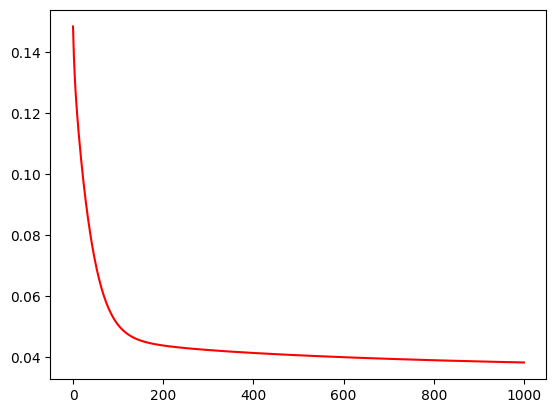

In [ ]:
# In order to use an iterative optimisation method we need an initial guess:

theta = np.zeros(M+1)

gd_losses = []
gd_losses.append(MSE_loss(X, y, theta))

# ... and a step size

eta = 1e-1

number_of_iteratons = 1000

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here

  theta = theta - eta*grad(X,y,theta)


  # ----------------------------
  loss = MSE_loss(X, y, theta)
  gd_losses.append(loss)
  if iter % 100 == 99:
    print(loss)

plt.plot(np.arange(len(gd_losses)),gd_losses, 'red')

**Question 5** Experiment different powers of ten for the step sizes $\eta$, empically what value is the largest for which you get good performance? What does this suggest about the smoothness of $L(\theta)$?

**Gradient Descent with Backtracing Line Search**

We will now optimise L using GD however we will use a line search method to select $\eta$ at each update according to the Armijo-Goldstein Condition with hyperparameter c.

\begin{align*}
f(\theta - \gamma_{t,k}\nabla f(\theta)) \leq f(\theta) - c \eta_{t,k} \| \nabla f(\theta)\|^2,
\end{align*}

In [ ]:
def check_armijo_goldstein_condtions(grad, loss, trail_point_loss, eta, c):
  grad_norm = np.linalg.norm(grad)
  if trail_point_loss <= loss - c * eta * grad_norm:
    return True
  else:
    return False

To run the backtracking line search we first select a trial point $\theta'$,  according to $\theta_0' = \theta_t - \eta_{t,0} \nabla f$ where $\eta_0 = \gamma$. If a trial point satisfies the acceptance condition, we set $\theta_t = \theta_t'$, otherwise  $\eta_{t,k+1} = \alpha \eta_{t,k}$. And select the next trail point according to $\theta_t' = \theta_t - \eta_{t,k} \nabla f$.

**Question 6** Implement GD with backtrackign line search and run if for 1000 steps, save the loss value after each step in the list 'line_search_losses'.

0.03725791773448236
0.03618655967227681
0.03608889182600326
0.0360888712907756
0.036088850758121176
0.03608883022803621
0.036088809700517165
0.03608878917556075
0.036088768653163884
0.03608874813332368


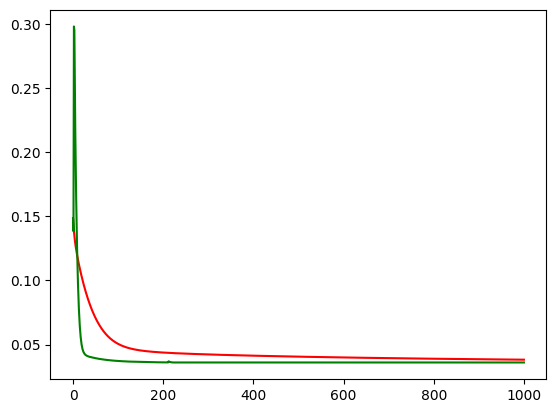

In [ ]:
theta = np.zeros(M+1)

line_search_losses = []
line_search_losses.append(MSE_loss(X, y, theta))

c = 0.001
gamma = 10
alpha = 0.8
max_k = 50 # make number of line search steps

number_of_iteratons = 1000
loss = MSE_loss(X, y, theta)

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here

  for k in range(max_k):
        trail_point = theta - eta * grad(X, y, theta)
        trail_point_loss = MSE_loss(X, y, trail_point)

        if check_armijo_goldstein_condtions(grad(X, y, theta), loss, trail_point_loss, eta, c):
            theta = trail_point
            break
        else:
            eta *= alpha  # reduce step size

  # once we have found a point that satisfies the condition we take a step using this step size
  # ----------------------------
  theta -= eta * grad(X,y,theta)
  eta = gamma # set eta back to its intial value

  loss = MSE_loss(X, y, theta)
  line_search_losses.append(loss)

  if iter % 100 == 99:
    print(loss)


plt.plot(np.arange(len(gd_losses)),gd_losses, 'red')
plt.plot(np.arange(len(line_search_losses)),line_search_losses, 'green')

**Gradient Descent with Momentum**

\begin{align*}
m_{0} &= 0,\\
m_{t} &= \mu m_{t-1} - \eta_t \nabla f(w_t),\\
w_{t+1} &= w_{t} + m_t.
\end{align*}

**Question 7** Implement GD with momentum for 1000 steps, save the loss value after each step in the list 'gd_with_momenutm_losses'. What do you notice when compairing against GD without Momentum?

0.04948924672183594
0.04379230247192201
0.04239272324329044
0.04142009159378251
0.04065386465697765
0.04001843439341219
0.03947877929955008
0.03901575704723939
0.038616862951416066
0.038272702538352285


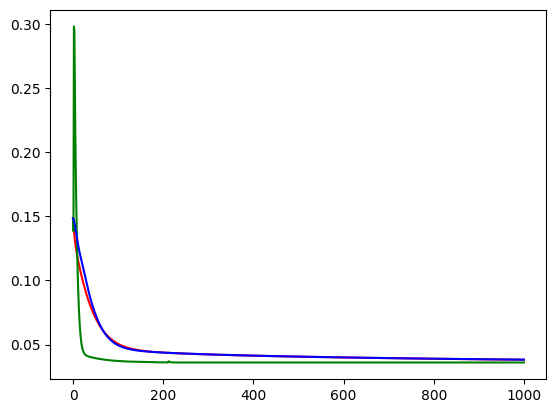

In [ ]:
theta = np.zeros(M+1)
momentum = np.zeros(M+1)

gd_with_momenutm_losses = []
gd_with_momenutm_losses.append(MSE_loss(X, y, theta))

# ... and a step size

eta = 1e-2
mu = 0.9

number_of_iteratons = 1000

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here

  momentum = mu*momentum - eta*grad(X,y,theta)
  theta = theta + momentum


  # ----------------------------
  loss = MSE_loss(X, y, theta)
  gd_with_momenutm_losses.append(loss)
  if iter % 100 == 99:
    print(loss)

plt.plot(np.arange(len(gd_losses)),gd_losses, 'red', label='gd')
plt.plot(np.arange(len(line_search_losses)),line_search_losses, 'green')
plt.plot(np.arange(len(gd_with_momenutm_losses)),gd_with_momenutm_losses, 'blue', label='gd_with_momentum')

**Gradient Descent with Nesterov Momentum**


\begin{align*}
m_{0} &= 0,\\
m_{t} &= \mu m_{t-1} - \eta_t \nabla f(w_t),\\
w_{t+1} &= w_{t} - \eta_t \nabla f(w_t) + \mu m_t.
\end{align*}

**###Optional### Question 8** Implement GD with nesterov momentum for 1000 steps, save the loss value after each step in the list 'gd_with_momenutm_losses'.

0.04961833366330903
0.04379218479815441
0.04238794584612567
0.041416226492731856
0.04065070695060433
0.040015914205889735
0.03947684127023714
0.03901432609984967
0.03861585473857683
0.03827203524324583


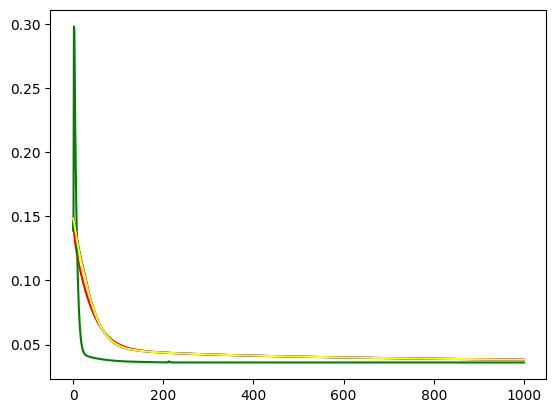

In [ ]:
theta = np.zeros(M+1)
momentum = np.zeros(M+1)

gd_with_nesterov_momenutm = []
gd_with_nesterov_momenutm.append(MSE_loss(X, y, theta))

# ... and a step size

eta = 1e-2
mu = 0.9

number_of_iteratons = 1000

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here

  momentum = mu*momentum - eta*grad(X,y,theta)
  theta = theta - eta*grad(X,y,theta) + mu*momentum

  # ----------------------------
  loss = MSE_loss(X, y, theta)
  gd_with_nesterov_momenutm.append(loss)
  if iter % 100 == 99:
    print(loss)

plt.plot(np.arange(len(gd_losses)),gd_losses, 'red', label='gd')
plt.plot(np.arange(len(line_search_losses)),line_search_losses, 'green')
plt.plot(np.arange(len(gd_with_momenutm_losses)),gd_with_momenutm_losses, 'blue', label='gd_with_momentum')
plt.plot(np.arange(len(gd_with_nesterov_momenutm)),gd_with_nesterov_momenutm, 'yellow', label='gd_with_momentum')

**Exact Second Order**

\begin{align*}
w_{t+1} = w_{t} -{H}_f^{-1}\nabla f(w_t).
\end{align*}

Where ${H}_f$ is the hessain.

**Question 9** Implement the exact second order optimiser 1000 steps, save the loss value after each step in the list 'second_order_losses'.

[ 1.14413754e-01 -5.29457873e-01  5.77696007e-02 -1.91455310e-01
  2.54474562e-02 -7.83035554e-02  1.02073605e-02 -2.69922990e-02
  2.00955537e-03  3.27326057e-04 -3.13684942e-03]
[-2.02859951e-13  1.18856036e-12 -4.23927560e-13  1.23996369e-12
 -4.37927472e-13  1.20674581e-12 -4.28634905e-13  1.16368026e-12
 -4.07962553e-13  1.12712895e-12 -3.89777099e-13]
[ 1.77635684e-15 -5.32907052e-16 -8.97060204e-15 -1.70974346e-15
 -2.33146835e-16 -4.66293670e-16 -7.99360578e-15  5.21804822e-16
 -4.37427872e-15 -6.80011603e-16 -3.24185123e-15]
[ 7.46069873e-15 -1.77635684e-16  2.39808173e-15  6.66133815e-17
  1.68198788e-14 -2.88657986e-16  3.37507799e-15 -5.44009282e-16
  6.99440506e-15  3.85802501e-16  8.12683254e-15]
[ 1.77635684e-15  1.77635684e-16  1.94511074e-14 -2.88657986e-16
 -5.91748872e-15  6.66133815e-17  3.37507799e-15  5.21804822e-16
  1.31006317e-15 -3.24740235e-16 -8.92619312e-15]
[ 7.46069873e-15 -1.77635684e-16 -1.46549439e-14  4.21884749e-16
 -2.33146835e-16 -6.43929354e-16  3

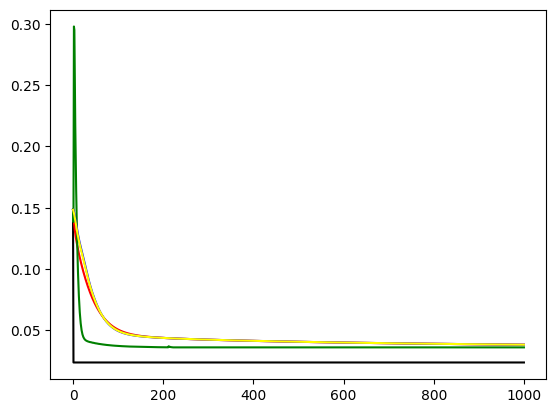

In [ ]:
theta = np.zeros(M+1)

second_order_losses = []
second_order_losses.append(MSE_loss(X, y, theta))

# ... note here we don't need learning rate

number_of_iteratons = 1000

def hessian(v):
  return 2/np.shape(v)[0] * np.matmul(v.T,v)

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here
  print(grad(X,y,theta))

  theta = theta - np.linalg.inv(hessian(X)).dot(grad(X,y,theta))

  # ----------------------------
  loss = MSE_loss(X, y, theta)
  second_order_losses.append(loss)
  if iter % 100 == 99:
    pass
    #print(loss)

plt.plot(np.arange(len(second_order_losses)),second_order_losses, 'black')
plt.plot(np.arange(len(gd_losses)),gd_losses, 'red', label='gd')
plt.plot(np.arange(len(line_search_losses)),line_search_losses, 'green')
plt.plot(np.arange(len(gd_with_momenutm_losses)),gd_with_momenutm_losses, 'blue', label='gd_with_momentum')
plt.plot(np.arange(len(gd_with_nesterov_momenutm)),gd_with_nesterov_momenutm, 'yellow', label='gd_with_momentum')


**Question 10** Try adjusting the learning rates, which optimier is quickest? How many steps does it take to converge? Why is this? Which is the second quickest?



**###Optional### BONUS MATERIAL**  - Gradient Free Optimiation



Gradient free optimisers are useful when the gradient can't easily be calculated. Instead of using the gradient they only use loss values. They start by picking a candidate direction $p$ and then evalulating the loss in the direction of $p$.


In this assignment you will code up the three point alogruthm that selects the next point according to:

\begin{equation}
w_{t+1} = \text{argmin}\{ f(w_t - \eta p_t), f(w_t), f(w_t + \eta p_t )\}
\end{equation}

(Where f represents our loss function)

In the coodinate descent optimiser $p_t$ is sampled from $\{e_1, e_2, \dots, e_d\}$ with equal probability where $e_i$ is the $i^{th}$ unit vertor.




**BONUS Question 11** Implement the a gradient free coodinate descent optimiser and run for 1000 steps, save the loss value after each step in the list 'coord_dec_losses'.

0.08495435413432277
0.05612052171460629
0.053615418734587764
0.04780175998115005
0.045244193774935215
0.04507125872276936
0.04507125872276936
0.043641739721764626
0.04223670673520327
0.04158459906104439


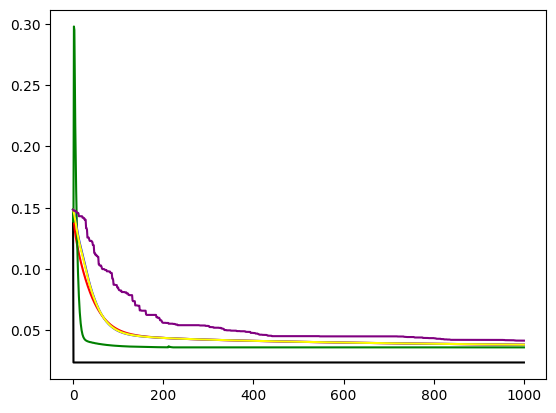

In [ ]:
theta = np.zeros(M+1)

coord_dec_losses = []
coord_dec_losses.append(MSE_loss(X, y, theta))

number_of_iteratons = 1000
eta = 0.1

# Creating our range of e values "ith unit vector"
e_vals = np.array([e for e in np.eye(M+1)])

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here
  # Select p first
  p = random.choice(e_vals)

  # Workout which of the 3 points gives the min loss
  points = [(theta - eta *p), theta, (theta + eta *p)]
  points_loss = [MSE_loss(X,y, point) for point in points]
  min_points_loss = np.min(points_loss)
  theta = points[points_loss.index(min_points_loss)]


  # --------------------------
  loss = MSE_loss(X, y, theta)
  coord_dec_losses.append(loss)
  eta *= 0.999
  if iter % 100 == 99:
    print(loss)

plt.plot(np.arange(len(second_order_losses)),second_order_losses, 'black')
plt.plot(np.arange(len(gd_losses)),gd_losses, 'red', label='gd')
plt.plot(np.arange(len(line_search_losses)),line_search_losses, 'green')
plt.plot(np.arange(len(gd_with_momenutm_losses)),gd_with_momenutm_losses, 'blue', label='gd_with_momentum')
plt.plot(np.arange(len(gd_with_nesterov_momenutm)),gd_with_nesterov_momenutm, 'yellow', label='gd_with_momentum')
plt.plot(np.arange(len(coord_dec_losses)),coord_dec_losses, 'purple')

**BONUS Question 12** Implement a gradient free optimiser that instead selects $p$ uniformly from the unit hyper-sphere of dimention $d$ (M+1) and run it for 1000 steps, save the loss value after each step in the list 'coord_dec_losses'.

0.04671991232052619
0.040079283843521996
0.03896394379116933
0.037697152950266516
0.03755161414838862
0.03718849202113668
0.03695809476802098
0.0368612289913731
0.03677873232212439
0.03673876282324244


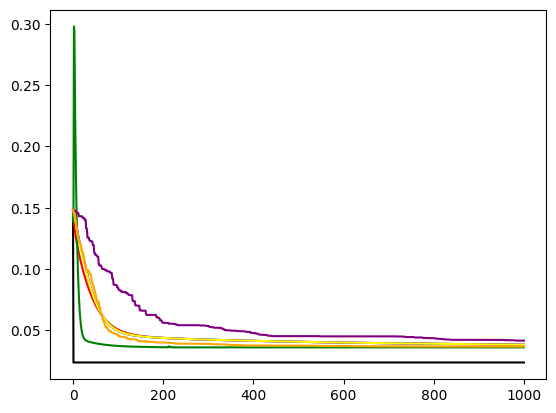

In [ ]:
theta = np.zeros(M+1)

grad_free_losses = []
grad_free_losses.append(MSE_loss(X, y, theta))

number_of_iteratons = 1000
eta = 0.1
# Creating our range of e values "ith unit vector"
def generate_p(n):
  p_unnorm = np.random.normal(0,1,n)
  p = p_unnorm / np.linalg.norm(p_unnorm)

  return p

for iter in range(number_of_iteratons):
  # ----------------------------
  # Your code here
  # (CHANGED CODE ABOVE AS WELL)
  # Select p first
  p = generate_p(M+1)

  # Workout which of the 3 points gives the min loss
  points = [(theta - eta *p), theta, (theta + eta *p)]
  points_loss = [MSE_loss(X,y, point) for point in points]
  min_points_loss = np.min(points_loss)
  theta = points[points_loss.index(min_points_loss)]

  # --------------------------
  loss = MSE_loss(X, y, theta)
  grad_free_losses.append(loss)
  eta *= 0.999
  if iter % 100 == 99:
    print(loss)

plt.plot(np.arange(len(second_order_losses)),second_order_losses, 'black')
plt.plot(np.arange(len(gd_losses)),gd_losses, 'red', label='gd')
plt.plot(np.arange(len(line_search_losses)),line_search_losses, 'green')
plt.plot(np.arange(len(gd_with_momenutm_losses)),gd_with_momenutm_losses, 'blue', label='gd_with_momentum')
plt.plot(np.arange(len(gd_with_nesterov_momenutm)),gd_with_nesterov_momenutm, 'yellow', label='gd_with_momentum')
plt.plot(np.arange(len(coord_dec_losses)),coord_dec_losses, 'purple')
plt.plot(np.arange(len(grad_free_losses)),grad_free_losses, 'orange')

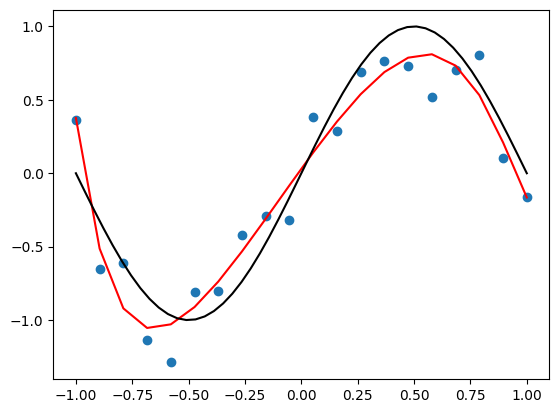

In [ ]:
# Run this cell if you want to visualise a final model
yhat = X@theta
plt.plot(x,y,'o', x, yhat, 'red')

# plot the true function
plt.plot(np.linspace(-1,1,50), np.sin(2*pi*.5*np.linspace(-1,1,50)), 'black')